# Setup and Imports




In [37]:
# Setup and imports
import os
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
PROJECT_ROOT = "/content/drive/MyDrive/emotion_recognition_project"
SAVE_DIR = os.path.join(PROJECT_ROOT, "mfcc_features")
os.makedirs(SAVE_DIR, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# MFCC Feature Extraction and Preprocessing

This section checks whether MFCC features and label encodings have already been saved. If not, it performs the following steps:

1. **Metadata Loading and Splitting**: A CSV file containing preprocessed audio file paths and emotion labels is loaded. The dataset is stratified and split into training and validation sets to preserve label distribution.

2. **Feature Extraction**: For each audio sample, the waveform is first loaded at its original sampling rate using `librosa`. Then, a set of 40 Mel-frequency cepstral coefficients (MFCCs) is computed to capture perceptually relevant spectral features. In addition, frame-wise root mean square (RMS) energy is extracted to supplement the MFCCs with information about signal intensity over time. These two components are vertically stacked to form a unified time-frequency representation of shape (41, T), where T is the number of frames. To standardize input dimensions across all samples, each feature matrix is either zero-padded or truncated along the time axis to a fixed length (`max_len = 216`). Finally, the resulting arrays are expanded with a singleton channel dimension to be compatible with convolutional neural network (CNN) input requirements.


3. **Encoding and Saving**: Labels are encoded into categorical format using `LabelEncoder` and one-hot encoding. All extracted features and labels are saved as `.npy` files for reuse in subsequent training sessions.



In [38]:
# Feature extraction and preprocessing
# Define paths for saved features
X_TRAIN_PATH = os.path.join(SAVE_DIR, "X_train.npy")
Y_TRAIN_PATH = os.path.join(SAVE_DIR, "y_train.npy")
X_VAL_PATH = os.path.join(SAVE_DIR, "X_val.npy")
Y_VAL_PATH = os.path.join(SAVE_DIR, "y_val.npy")
LABEL_MAP_PATH = os.path.join(SAVE_DIR, "label_map.csv")

# Check if features have already been extracted
features_exist = os.path.exists(X_TRAIN_PATH) and os.path.exists(Y_TRAIN_PATH) and \
                os.path.exists(X_VAL_PATH) and os.path.exists(Y_VAL_PATH)

if not features_exist:
    print("Features not found. Extracting MFCC features...")

    # Load your processed metadata
    METADATA_PATH = os.path.join(PROJECT_ROOT, "processed_metadata.csv")
    print(f"Loading metadata from: {METADATA_PATH}")

    metadata = pd.read_csv(METADATA_PATH)
    print(f"Loaded {len(metadata)} audio files metadata")

    # Split metadata into train and validation sets (stratify by label)
    train_meta, val_meta = train_test_split(
        metadata, test_size=0.2, stratify=metadata["label"], random_state=42
    )

    def load_audio_segment(path):
        """Load audio file that's already been processed to standard length"""
        y, sr = librosa.load(path, sr=None)  # Use the file's native sample rate
        return y, sr

    def extract_mfcc_with_energy(y, sr=16000, n_mfcc=40, max_len=216):
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        energy = librosa.feature.rms(y=y)[0].reshape(1, -1)
        combined = np.vstack([mfcc, energy])
        if combined.shape[1] < max_len:
            pad_width = max_len - combined.shape[1]
            combined = np.pad(combined, ((0, 0), (0, pad_width)), mode="constant")
        else:
            combined = combined[:, :max_len]
        return combined

    # Feature extraction
    X_train_list, y_train_list = [], []
    X_val_list, y_val_list = [], []

    # Training set
    for _, row in tqdm(train_meta.iterrows(), total=len(train_meta)):
        path, label = row["processed_path"], row["label"]
        try:
            y_raw, sr = load_audio_segment(path)
            features = extract_mfcc_with_energy(y_raw, sr=sr)
            X_train_list.append(features)
            y_train_list.append(label)
        except Exception as e:
            print(f"Error with {path}: {e}")

    # validation set
    for _, row in tqdm(val_meta.iterrows(), total=len(val_meta)):
        path, label = row["processed_path"], row["label"]
        try:
            y_raw, sr = load_audio_segment(path)
            features = extract_mfcc_with_energy(y_raw, sr=sr)
            X_val_list.append(features)
            y_val_list.append(label)
        except Exception as e:
            print(f"Error with {path}: {e}")

    # Saving features
    X_train = np.expand_dims(np.array(X_train_list), -1)
    X_val = np.expand_dims(np.array(X_val_list), -1)

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train_list)
    y_val_enc = le.transform(y_val_list)
    y_train_cat = tf.keras.utils.to_categorical(y_train_enc)
    y_val_cat = tf.keras.utils.to_categorical(y_val_enc)

    np.save(X_TRAIN_PATH, X_train)
    np.save(Y_TRAIN_PATH, y_train_cat)
    np.save(X_VAL_PATH, X_val)
    np.save(Y_VAL_PATH, y_val_cat)

    pd.DataFrame({
        "label": le.classes_,
        "code": le.transform(le.classes_)
    }).to_csv(LABEL_MAP_PATH, index=False)

    print("Feature extraction completed!")
    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)
    print("y_train shape:", y_train_cat.shape)
    print("y_val shape:", y_val_cat.shape)

else:
    print("Found existing MFCC features. Loading from files...")

Found existing MFCC features. Loading from files...


# Dataset Loading and Preprocessing


This section prepares the input data for model training. It includes three key steps:

1. **Loading Preprocessed Features**:  
   The MFCC features and one-hot encoded labels for both the training and validation sets are loaded from `.npy` files. These features were previously extracted and saved to disk to avoid redundant computation. The loaded feature shapes are:
   - `X_train`: (9729, 41, 216, 1)
   - `y_train`: (9729, 7)
   - `X_val`: (2433, 41, 216, 1)
   - `y_val`: (2433, 7)

2. **Restoring Label Mapping**:  
   A CSV file is read to restore the mapping between emotion labels (e.g., "angry", "happy") and their corresponding integer codes. This ensures consistency between training and evaluation stages.

3. **Feature Standardization**:  
   To normalize the input features, the global mean and standard deviation of the training set are computed. Both training and validation features are then standardized. This helps improve training stability and model convergence. In practice, this standardization led to an approximate 1% increase in classification accuracy.

4. **TensorFlow Dataset Creation**:  
   The standardized feature arrays and labels are wrapped into `tf.data.Dataset` objects with shuffling and prefetching enabled. This pipeline improves GPU utilization and allows for efficient mini-batch training with `BATCH_SIZE = 32`.



In [39]:
# Load features and prepare datasets
# Load Preprocessed Train & Val Sets
X_train = np.load(X_TRAIN_PATH)
y_train = np.load(Y_TRAIN_PATH)
X_val = np.load(X_VAL_PATH)
y_val = np.load(Y_VAL_PATH)

print("Loaded features from files:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

# Load label mapping
label_mapping = pd.read_csv(LABEL_MAP_PATH)
labels = label_mapping["label"].values
print("Labels:", labels)

# Standardize features => Improved the acc by 1%
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


Loaded features from files:
X_train shape: (9729, 41, 216, 1)
y_train shape: (9729, 7)
X_val shape: (2433, 41, 216, 1)
y_val shape: (2433, 7)
Labels: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


# Custom Classification Report

Defines a utility function to print a formatted classification report using `sklearn` metrics. This includes precision, recall, and F1-scores for each class, as well as macro and weighted averages, making evaluation results easier to interpret.


In [40]:
# Defining the custom display function for classification reports
def display_classification_report(y_true, y_pred, labels):
    """Display classification report in a nicely formatted table"""
    # Get the classification report as a dictionary
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)

    # Create a DataFrame from the report
    df = pd.DataFrame()

    # Add all class metrics
    for label in labels:
        df = df.append(pd.Series({
            'precision': report[label]['precision'],
            'recall': report[label]['recall'],
            'f1-score': report[label]['f1-score'],
            'support': report[label]['support']
        }), ignore_index=True)

    # Add summary metrics
    df = df.append(pd.Series({
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1-score': report['macro avg']['f1-score'],
        'support': report['macro avg']['support']
    }), ignore_index=True)

    df = df.append(pd.Series({
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1-score': report['weighted avg']['f1-score'],
        'support': report['weighted avg']['support']
    }), ignore_index=True)

    # Set index names
    df.index = list(labels) + ['macro avg', 'weighted avg']

    # Format and display
    pd.set_option('display.float_format', '{:.2f}'.format)
    print("\nClassification Report:")
    print(df)
    return df

# Experiment1: CNN-BiLSTM Model with Attention


This section defines and trains a model for speech emotion recognition. The architecture combines convolutional layers, a bidirectional LSTM, and an attention mechanism to effectively capture both local spectral patterns and long-range temporal dependencies in MFCC-based features.

### Model Architecture

- **Input Layer**:  
  Accepts MFCC inputs of shape `(41, 216, 1)`, where 41 represents 40 MFCC coefficients + 1 energy feature, and 216 is the fixed time dimension.

- **CNN Block**:  
  Two convolutional blocks are applied, each consisting of:
  - `Conv2D` with 64 filters and `(3, 3)` kernels to learn local time-frequency patterns.
  - `BatchNormalization` to stabilize training.
  - `MaxPooling2D` for downsampling.
  - `Dropout` with rate 0.3 for regularization.

- **Reshaping Layer**:  
  The 3D feature map is reshaped into a 2D sequence format suitable for recurrent layers: `(time_steps, features)`.

- **BiLSTM Layer**:  
  A bidirectional LSTM with 16 units captures contextual dependencies from both past and future time steps. L2 regularization (`λ = 0.005`) is applied to mitigate overfitting.

- **Attention Mechanism**:  
  - A single dense layer computes raw attention scores over time.
  - `Softmax` normalizes these into attention weights.
  - A context vector is computed as the weighted sum of the BiLSTM outputs.
  - Additional `Dropout` (rate 0.4) is applied after attention pooling.

- **Output Layers**:  
  - A fully connected dense layer with 64 units and L2 regularization for final representation learning.
  - A softmax output layer maps to 7 emotion categories.

### Model Compilation and Training Settings

- **Loss Function**:  
  `categorical_crossentropy` is used for multi-class classification on one-hot encoded labels.

- **Optimizer**:  
  `Adam` optimizer is chosen for efficient convergence.

- **Metrics**:  
  - `accuracy`: Standard classification accuracy.
  - `TopKCategoricalAccuracy (k=3)`: Measures whether the true label is among the top 3 predicted probabilities.

- **Training Callbacks**:
  - `ReduceLROnPlateau`: Reduces learning rate by half if validation loss does not improve for 3 consecutive epochs.
  - `EarlyStopping`: Stops training if validation loss does not improve for 6 epochs and restores the best model.
  - `ModelCheckpoint`: Saves the model with the highest validation accuracy to disk.

- **Training Configuration**:  
  The model is trained for up to 50 epochs using the TensorFlow `fit()` API on preprocessed `train_ds` and `val_ds` datasets.

### Model Selection and Training Insights

Multiple model configurations were explored to identify the optimal architecture for this integrated emotional speech dataset. The following insights summarize the experimental findings:

- **Convolutional Blocks**:  
  Models with 1, 2, 4, and 5 convolutional blocks were tested. Increasing the number of blocks beyond two consistently led to severe overfitting, as evidenced by a widening gap between training and validation accuracy. Additionally, deeper CNN stacks significantly increased training time due to the higher number of parameters.

- **Dropout Rates**:  
  Various dropout rates in the range of 0.2 to 0.5 were evaluated. The final configuration uses 0.3 after convolutional blocks and 0.4–0.5 in the attention and dense layers, which provided the best balance between generalization and performance.

- **Optimizers**:  
  Multiple optimizers were experimented with, including **Adam**, **RMSprop**, and **SGD** (with momentum). *Adam* consistently offered the fastest convergence and the most stable results, especially with learning rate scheduling.  

- **Final Decision**:  
  Based on validation performance and training efficiency, the current architecture—comprising two convolutional blocks, a BiLSTM with attention, moderate dropout, and the Adam optimizer—was selected as the final model. It provided the best trade-off between accuracy, robustness, and computational cost.






In [41]:
# CNN-BiLSTM Model Definition and Training
print("\n CNN-BiLSTM with Attention Model")

def build_regularized_cnn_bilstm(input_shape=(41, 216, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    # CNN Block
    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Reshape for RNN
    x = layers.Reshape((x.shape[1], -1))(x)

    # BiLSTM
    x = layers.Bidirectional(
        layers.LSTM(16, return_sequences=True, kernel_regularizer=regularizers.l2(0.005))
    )(x)

    # Attention Block
    attention = layers.Dense(1, activation='tanh')(x)
    attention_weights = layers.Softmax(axis=1)(attention)
    context_vector = layers.Multiply()([x, attention_weights])
    context_vector = layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(context_vector)
    context_vector = layers.Dropout(0.4)(context_vector)

    # Output Layer
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005))(context_vector)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

model1 = build_regularized_cnn_bilstm(input_shape=X_train.shape[1:], num_classes=y_train.shape[1])
model1.summary()

model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_acc')]
)

callbacks1 = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(os.path.join(SAVE_DIR, "best_cnn_bilstm_model.keras"),
                  save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
]

history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks1
)


 CNN-BiLSTM with Attention Model


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 41, 216,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 41, 216,   │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 216,   │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 20, 108,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 20, 108,   │          0 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 20, 108,   │     36,928 │ dropout_9[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 108,   │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 10, 54,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 10, 54,    │          0 │ max_pooling2d_7[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 10, 3456)  │          0 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 10, 32)    │    444,544 │ reshape_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10, 1)     │         33 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 10, 1)     │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 10, 32)    │          0 │ bidirectional_1[… │
│ (Multiply)          │                   │            │ softmax_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 32)        │          0 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32)        │          0 │ lambda_1[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      2,112 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64)        │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 485,224 (1.85 MB)

 Trainable params: 484,968 (1.85 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1977 - loss: 2.5217 - top_3_acc: 0.5237
Epoch 1: val_accuracy improved from -inf to 0.15947, saving model to /content/drive/MyDrive/emotion_recognition_project/mfcc_features/best_cnn_bilstm_model.keras
305/305 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.1981 - loss: 2.5184 - top_3_acc: 0.5244 - val_accuracy: 0.1595 - val_loss: 2.2267 - val_top_3_acc: 0.4718 - learning_rate: 0.0010
Epoch 2/50
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3086 - loss: 1.8440 - top_3_acc: 0.7207
Epoch 2: val_accuracy improved from 0.15947 to 0.36416, saving model to /content/drive/MyDrive/emotion_recognition_project/mfcc_features/best_cnn_bilstm_model.keras
305/305 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.3089 - loss: 1.8436 - top_3_acc: 0.7210 - val_accuracy: 0.3642 - val_loss: 1.8299 - val_top_3_acc: 0.6786 - learning_rate: 0.0010
Epoch 3/50
303/305 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4177 - loss: 1.706

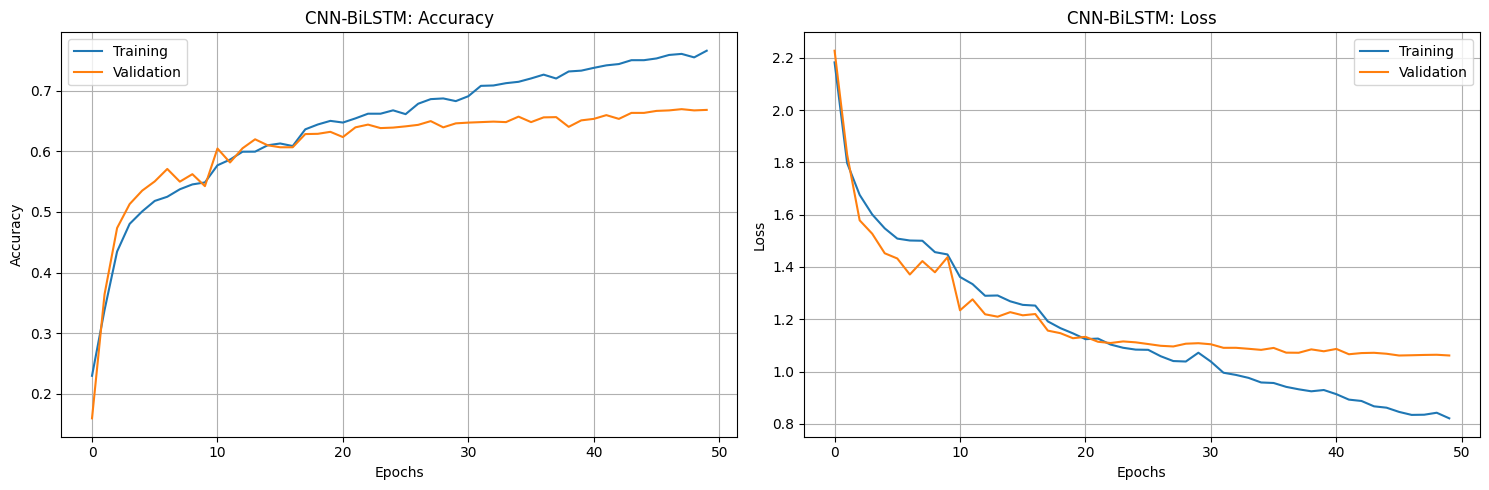

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


<Figure size 1000x800 with 0 Axes>

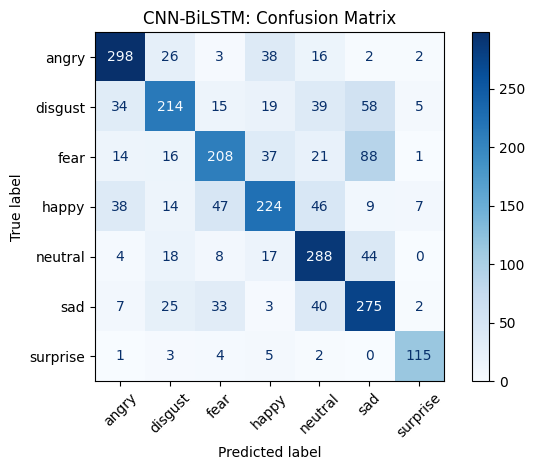


CNN-BiLSTM Model Evaluation:
              precision  recall  f1-score  support
angry              0.75    0.77      0.76   385.00
disgust            0.68    0.56      0.61   384.00
fear               0.65    0.54      0.59   385.00
happy              0.65    0.58      0.62   385.00
neutral            0.64    0.76      0.69   379.00
sad                0.58    0.71      0.64   385.00
surprise           0.87    0.88      0.88   130.00
accuracy           0.67    0.67      0.67     0.67
macro avg          0.69    0.69      0.68  2433.00
weighted avg       0.67    0.67      0.66  2433.00


In [42]:
# CNN-BiLSTM Model Visualization and Evaluation
# Plot accuracy and loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history1.history["accuracy"], label="Training")
plt.plot(history1.history["val_accuracy"], label="Validation")
plt.title("CNN-BiLSTM: Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history1.history["loss"], label="Training")
plt.plot(history1.history["val_loss"], label="Validation")
plt.title("CNN-BiLSTM: Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on validation set
y_pred1 = model1.predict(X_val).argmax(axis=1)
y_true1 = y_val.argmax(axis=1)

# Confusion matrix
plt.figure(figsize=(10, 8))
cm1 = confusion_matrix(y_true1, y_pred1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
disp1.plot(cmap="Blues", values_format='d', xticks_rotation=45)
plt.title("CNN-BiLSTM: Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report as table
print("\nCNN-BiLSTM Model Evaluation:")
report_df1 = pd.DataFrame(classification_report(y_true1, y_pred1, target_names=labels, output_dict=True)).transpose()
print(report_df1.round(2))

### CNN+LSTM+Attention: Training and Evaluation Analysis

#### 1. Training Overview
- The model achieved its highest validation accuracy of approximately **66.8%** around epoch 46.
- The validation **Top-3 Accuracy** reached **91.6%**, indicating that the model was often able to include the correct label within its top three predictions.
- The learning rate scheduler successfully reduced the learning rate to around `1.56e-5`, contributing to training stability in later epochs.

#### 2. Accuracy and Loss Trends
- Training accuracy steadily increased to approximately **75.8%**, while validation accuracy plateaued near **66.8%**, indicating stable learning without significant overfitting.
- Both training and validation loss consistently decreased. Validation loss began to stabilize after around 20 epochs, suggesting model convergence.

#### 3. Confusion Matrix Interpretation
- Emotions like **sad** and **neutral** were most reliably classified, with 275 and 288 correct predictions, respectively.
- Common misclassifications include:
  - **fear** frequently misclassified as **sad** or **neutral**.
  - Moderate confusion between **happy** and **angry**.
- Despite its lower sample count (138), the **surprise** category maintained relatively strong performance.

#### 4. Classification Summary
- The model achieved an overall accuracy of **67%**, which is competitive for multi-class speech emotion recognition on a merged dataset.
- Both **macro** and **weighted average F1-scores** reached **0.66**, indicating balanced performance across categories.
- The best-performing class was **angry** (*F1 = 0.76*), while **neutral** and **fear** were more challenging (*F1 ≈ 0.58–0.59*).

These results suggest that the model is capable of generalizing well across a diverse set of emotional categories, with particularly strong Top-3 classification performance.


# Experiment 2: Deep CNN Model

### Model Architecture

This model adopts a deep `Sequential` convolutional structure with four stacked Conv2D blocks, followed by a dense classification head:

- Each convolutional block consists of `Conv2D → BatchNormalization → ReLU → MaxPooling2D → Dropout`.
- Filter sizes progressively increase as `[32, 64, 128, 256]`, while dropout rates grow from 0 to 0.2 across layers to improve regularization.
- The final dense layer uses 256 units with `ReLU` activation and optional L2 regularization.

### Experimental Exploration and Training Adjustments

- **Conv1D vs Conv2D**:  
  Both 1D and 2D convolutional models were tested. Conv2D consistently performed better on MFCC-based inputs, as it can capture joint time-frequency patterns more effectively.

- **Block Depth**:  
  Models with 1 to 5 convolutional blocks were evaluated. Shallower networks underfit the training data, while deeper ones suffered from overfitting and longer training times. A four-block architecture provided the best trade-off.

- **Dropout Rates**:  
  Various dropout strategies were explored, ranging from no dropout to configurations like `[0.3, 0.3, 0.4, 0.5]`. Gradually increasing dropout across layers yielded the best validation performance without harming convergence.

- **Regularization**:  
  L2 regularization (`kernel_regularizer=l2`) was applied to the final dense layer with values of `0.001` and `0.002`. The former led to more stable training and better generalization, and was thus retained in the final setup.

### Final Model Choice

The selected model, comprising 4 convolutional blocks, progressive dropout, and L2-regularized dense layers, demonstrated the most stable and generalizable performance across training and validation. It was ultimately used for downstream evaluation and comparison.


In [46]:
# Deep CNN Model Definition and Training
print("\nDeep CNN Model")

def build_deep_cnn(input_shape=(41, 216, 1), num_classes=7):
    model = models.Sequential()
    model.add(tf.keras.Input(shape=input_shape))

    for filters, dropout in zip([32, 64, 128, 256], [0, 0, 0.1, 0.2]):
        model.add(layers.Conv2D(filters, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(dropout))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu',
                         kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

model2 = build_deep_cnn(input_shape=X_train.shape[1:], num_classes=y_train.shape[1])
model2.summary()

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_acc')]
)

callbacks2 = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint(os.path.join(SAVE_DIR, "best_deep_cnn_model.keras"),
                  save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
]

history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks2
)



Deep CNN Model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 41, 216, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 41, 216, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 41, 216, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 20, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 20, 108, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 20, 108, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 20, 108, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 20, 108, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 10, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 10, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 54, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 10, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 5, 27, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 5, 27, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 5, 27, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 5, 27, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 2, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 2, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6656)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     1,704,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             

 Total params: 2,095,751 (7.99 MB)

 Trainable params: 2,094,791 (7.99 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1931 - loss: 3.3366 - top_3_acc: 0.5440
Epoch 1: val_accuracy improved from -inf to 0.25113, saving model to /content/drive/MyDrive/emotion_recognition_project/mfcc_features/best_deep_cnn_model.keras
305/305 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.1932 - loss: 3.3334 - top_3_acc: 0.5442 - val_accuracy: 0.2511 - val_loss: 1.9879 - val_top_3_acc: 0.6358 - learning_rate: 0.0010
Epoch 2/50
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2513 - loss: 1.9023 - top_3_acc: 0.6505
Epoch 2: val_accuracy improved from 0.25113 to 0.28977, saving model to /content/drive/MyDrive/emotion_recognition_project/mfcc_features/best_deep_cnn_model.keras
305/305 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2514 - loss: 1.9018 - top_3_acc: 0.6506 - val_accuracy: 0.2898 - val_loss: 1.7429 - val_top_3_acc: 0.7189 - learning_rate: 0.0010
Epoch 3/50
301/305 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2737 - loss: 1.7997 - t

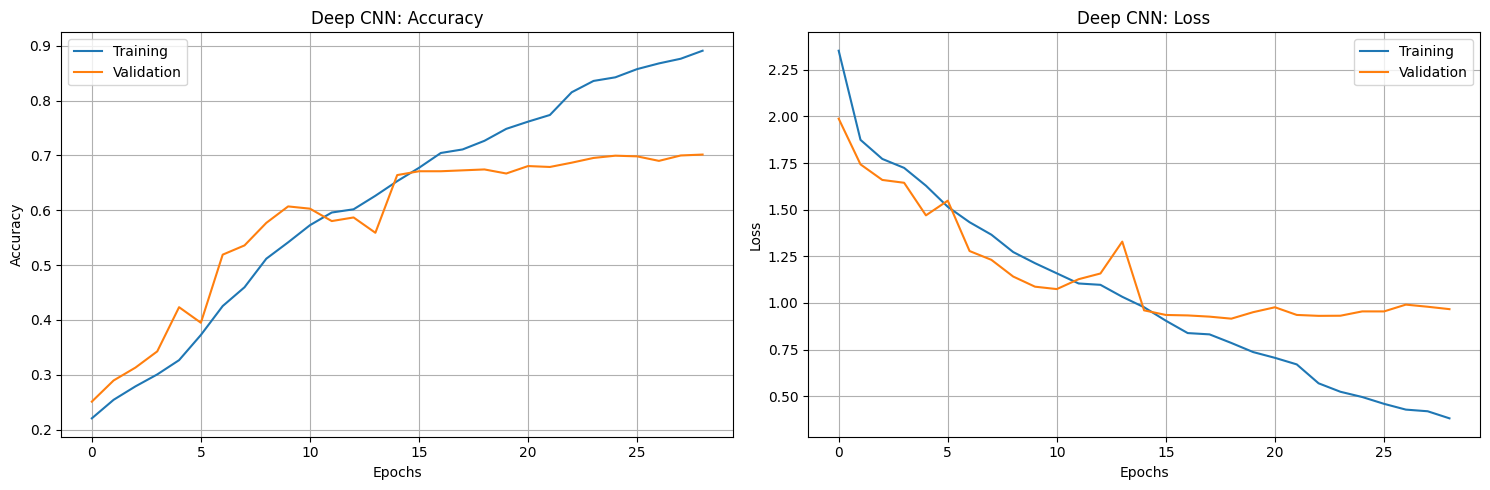

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


<Figure size 1000x800 with 0 Axes>

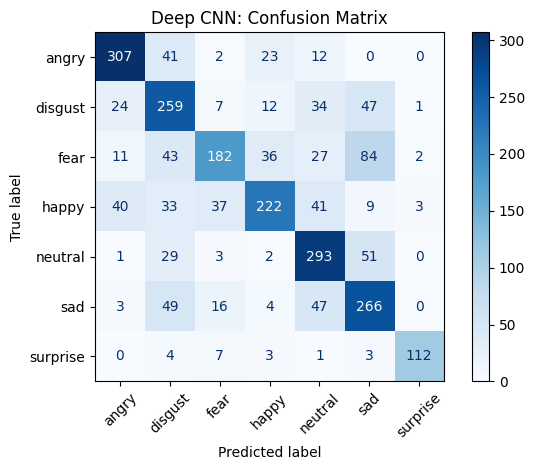


Deep CNN Model Evaluation:
              precision  recall  f1-score  support
angry              0.80    0.80      0.80   385.00
disgust            0.57    0.67      0.62   384.00
fear               0.72    0.47      0.57   385.00
happy              0.74    0.58      0.65   385.00
neutral            0.64    0.77      0.70   379.00
sad                0.58    0.69      0.63   385.00
surprise           0.95    0.86      0.90   130.00
accuracy           0.67    0.67      0.67     0.67
macro avg          0.71    0.69      0.69  2433.00
weighted avg       0.69    0.67      0.67  2433.00


In [47]:
# Deep CNN Model Visualization and Evaluation
# Plot accuracy and loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history["accuracy"], label="Training")
plt.plot(history2.history["val_accuracy"], label="Validation")
plt.title("Deep CNN: Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history2.history["loss"], label="Training")
plt.plot(history2.history["val_loss"], label="Validation")
plt.title("Deep CNN: Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate on validation set
y_pred2 = model2.predict(X_val).argmax(axis=1)
y_true2 = y_val.argmax(axis=1)

# Confusion matrix
plt.figure(figsize=(10, 8))
cm2 = confusion_matrix(y_true2, y_pred2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)
disp2.plot(cmap="Blues", values_format='d', xticks_rotation=45)
plt.title("Deep CNN: Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report as table
print("\nDeep CNN Model Evaluation:")
report_df2 = pd.DataFrame(classification_report(y_true2, y_pred2,
                                             target_names=labels,
                                             output_dict=True,
                                             zero_division=1)).transpose()
print(report_df2.round(2))

## Deep CNN: Training and Evaluation Analysis

### 1. Training Overview
- The model reached its peak validation accuracy of **70.16%** at epoch 19, with a final training accuracy of **80.1%**.
- The validation **Top-3 Accuracy** peaked at **93.05%**, indicating strong secondary classification performance.
- The learning rate scheduler effectively reduced the rate from `0.001` to `6.25e-5`, contributing to smooth and stable convergence.

### 2. Accuracy and Loss Trends
- Training accuracy steadily increased to approximately **90%**, while validation accuracy plateaued around **70%**.
- Although there is a mild generalization gap, it remains within acceptable bounds, indicating moderate overfitting.
- Validation loss stabilized after epoch 15, suggesting the model had fully converged.

### 3. Confusion Matrix Interpretation
- Best-performing classes:
  - **angry** and **surprise** achieved the highest F1-scores (0.80 and 0.86 respectively).
  - **neutral** and **happy** also showed consistent classification performance.
- Most challenging classes:
  - **fear** was frequently confused with **sad** and **neutral**, with a recall of only 0.47.
  - **sad** displayed moderate confusion, particularly with **fear** and **neutral**.
- The model demonstrated reliable performance across the majority of emotional categories.

### 4. Classification Summary
- The model achieved an overall accuracy of **67%**, comparable to the CNN-BiLSTM model.
- **Macro-average F1-score = 0.69**, **Weighted-average F1-score = 0.67**, indicating balanced classification across emotion categories.
- The **surprise** category yielded the highest class-specific performance (F1 = 0.86), possibly due to distinctive acoustic features and consistent labeling.

Overall, the Deep CNN model provides competitive results and demonstrates strong potential for emotion recognition tasks.


In [48]:
# Model Comparison
print("\nModel Performance Comparison")
max_val_acc1 = max(history1.history["val_accuracy"])
max_val_acc2 = max(history2.history["val_accuracy"])

comparison_data = {
    "Model": ["CNN-BiLSTM", "Deep CNN"],
    "Max Validation Accuracy": [max_val_acc1, max_val_acc2],
    "Parameters": [model1.count_params(), model2.count_params()]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.round(4))


Model Performance Comparison
        Model  Max Validation Accuracy  Parameters
0  CNN-BiLSTM                   0.6695      485224
1    Deep CNN                   0.7016     2095751


# Final Conclusion: Model Analysis to MFCC Features

In this study, multiple deep learning architectures were evaluated for speech emotion recognition using MFCC features. Considering both validation accuracy and model complexity, the two best-performing models are:

- **Deep CNN**: Achieved a maximum validation accuracy of **70.16%** with approximately **2.1 million** parameters.
- **CNN-BiLSTM**: Achieved a maximum validation accuracy of **66.95%** with approximately **0.48 million** parameters.

Although the Deep CNN has a significantly higher parameter count, it outperformed the recurrent model under a purely convolutional architecture. This performance advantage may be attributed to several factors:

- **MFCC is a static 2D time-frequency representation**, which lacks the raw temporal dynamics of the original audio waveform. As a result, the temporal modeling capabilities of BiLSTM provide limited benefit in this context.

- In contrast, **deep CNNs can better exploit local and multi-scale patterns across the time-frequency plane**, making them more effective at capturing spatial structure inherent to MFCC inputs.

- The Deep CNN further benefited from **layer-wise dropout regularization and deeper representational capacity**, which contributed to improved generalization—particularly on the integrated multi-dataset used in this experiment.

In summary, for tasks using MFCCs as input features, deep convolutional models may be more suitable than sequence-based architectures, as they align better with the spatial characteristics of MFCCs and offer stronger performance on this dataset.
